# Simulating stacks vs non-stacks

This is a notebook to test how stacking of galaxy clusters and hierarchical models work in triaxial clusters.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(linewidth=400)

In [3]:
import xlensing
from astropy.table import Table

Lookup table loaded!


In [4]:
mass = 1e14 # mass in Msun/h
concentration = 4.
nfw_z_halo = 0.3
RA = 0
DEC = 0


## Testing basic functions

In [5]:
xlensing.sims.rhoM(z=nfw_z_halo)

113160009026.94252

In [6]:
xlensing.sims.r_vir(nfw_z_halo, mass)

1.0179570954383916

In [7]:
xlensing.sims.critical_density(0.3,1.0)

array(4.04864605e+15)

In [8]:
xlensing.sims.NFW_tangential_shear(1e14, 4, 0.3, 1.0, .15)

array(0.02697304)

In [9]:
xlensing.sims.NFW_wcs_cluster_shear(1e14,4,0.3,1.0,0,0,0.000,-0.0003)

(0.024270067331205302-5.944452054450264e-18j)

In [10]:
gamma = xlensing.sims.NFW_wcs_cluster_shear(1e14,4,0.3,1.0,0,0,0.000,0.001)

xlensing.sims.add_shears(0.3+.0j,gamma)

(0.309372474969615+0j)

In [11]:
simplecat = xlensing.sims.make_simple_random_cat(10, width_rad=4./xlensing.cosmo.DA(0,0.3), zrange=[0.2,0.1], shape_noise=0.3)
simplecat = Table(simplecat.T,names=['ra','dec','z','e1','e2','R11','R12','R21','R22','w'])

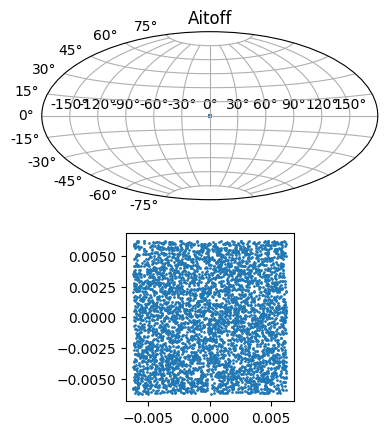

In [12]:
subplot(211, projection="aitoff")
scatter(simplecat['ra'],simplecat['dec'],s=1)
title("Aitoff")
grid(True)
subplot(212)
scatter(simplecat['ra'],simplecat['dec'],s=1)
ax = plt.gca()
ax.set_aspect('equal')

## 1 - Generate background galaxy catalogue

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/LSC/vitorelli/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import gc
# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
import glass.observations
import glass.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 512

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

In [15]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 3., dx=200.)

# tophat window functions for shells
ws = glass.shells.tophat_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.camb.matter_cls(pars, lmax, ws)

# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

In [16]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

In [17]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 30.0

# true redshift distribution following a Smail distribution
z = np.arange(0., 3., 0.01)
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_arcmin2

# compute bin edges with equal density
nbins = 10
zedges = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# split distribution by tomographic bin, assuming photometric redshift errors
tomo_nz = glass.observations.tomo_nz_gausserr(z, dndz, sigma_z0, zedges)

# constant bias parameter for all shells
bias = 1.2

# ellipticity standard deviation as expected for a Stage-IV survey
sigma_e = 0.27


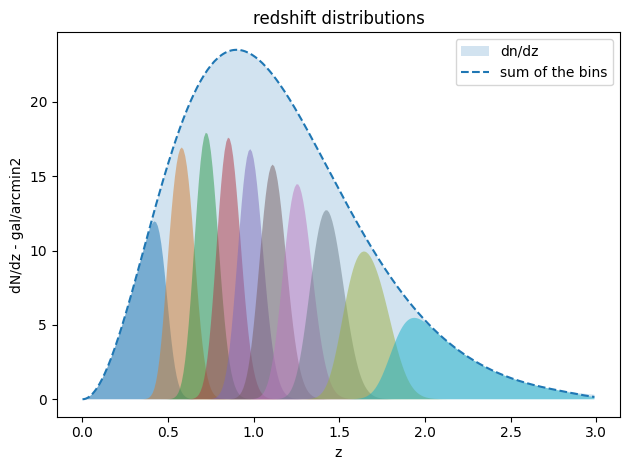

In [18]:
plt.figure()
plt.title('redshift distributions')
sum_nz = np.zeros_like(tomo_nz[0])
for nz in tomo_nz:
    plt.fill_between(z, nz, alpha=0.5)
    sum_nz = sum_nz + nz
plt.fill_between(z, dndz, alpha=0.2, label='dn/dz')
plt.plot(z, sum_nz, ls='--', label='sum of the bins')
plt.ylabel('dN/dz - gal/arcmin2')
plt.xlabel('z')
plt.legend()
plt.tight_layout()

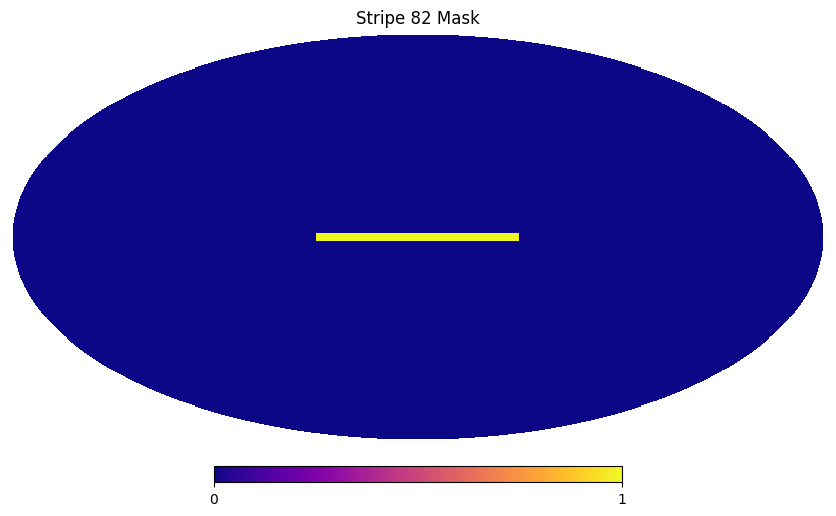

In [19]:
nside = 512
def mask_map_val(_nside,_ipix):
    """Mask loops and latitude"""
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 0
    #STRIPE
    if ((l<45)or(l>315)) and (abs(b)<1.5):
      cue = 1

    return cue

mask_map = np.zeros(hp.nside2npix(nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(nside, i)

# Presents the generated mask map
hp.mollview(mask_map, cmap='plasma',title="Stripe 82 Mask")

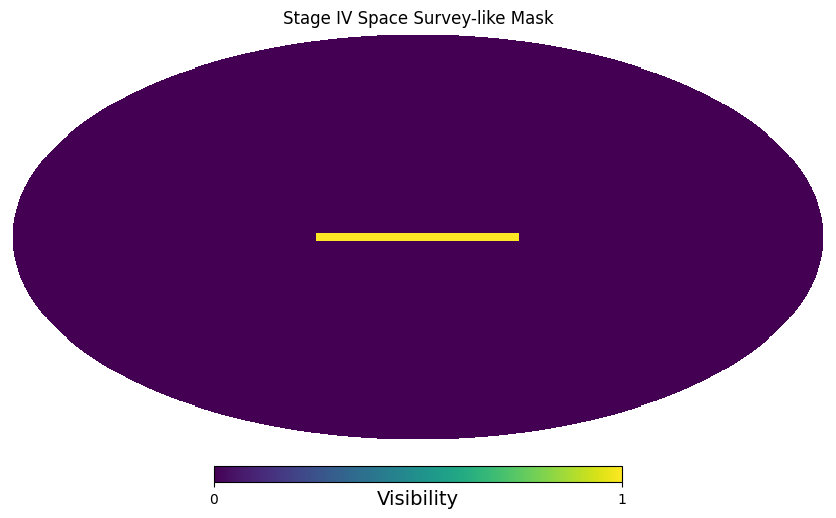

In [20]:
vis = mask_map

# checking the mask:
hp.mollview(vis, title='Stage IV Space Survey-like Mask', unit='Visibility')
plt.show()

In [21]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(0, dtype=[('RA', float), ('DEC', float), ('TRUE_Z', float),
                               ('G1', float), ('G2', float), ('TOMO_ID', int)])
# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):

    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # the true galaxy distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # the photometric galaxy distribution in this shell
    tomo_z_i, tomo_nz_i = glass.shells.restrict(z, tomo_nz, ws[i])

    # integrate dndz to get the total galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # generate galaxy positions from the matter density contrast
    gal_lon, gal_lat = glass.points.positions_from_delta(ngal, delta_i, bias, vis)

    # number of galaxies in this shell
    gal_siz = len(gal_lon)

    # generate random redshifts from the provided nz
    gal_z, gal_pop = glass.galaxies.redshifts_from_nz(gal_siz, tomo_z_i, tomo_nz_i)

    # generate galaxy ellipticities from the chosen distribution
    gal_eps = glass.shapes.ellipticity_intnorm(gal_siz, sigma_e)

    # apply the shear fields to the ellipticities
    gal_she = glass.galaxies.galaxy_shear(gal_lon, gal_lat, gal_eps,
                                          kappa_i, gamm1_i, gamm2_i)

    # make a mini-catalogue for the new rows
    rows = np.empty(gal_siz, dtype=catalogue.dtype)
    rows['RA'] = gal_lon
    rows['DEC'] = gal_lat
    rows['TRUE_Z'] = gal_z
    rows['G1'] = gal_she.real
    rows['G2'] = gal_she.imag
    rows['TOMO_ID'] = gal_pop

    # add the new rows to the catalogue
    catalogue = np.append(catalogue, rows)
    
    
print(f'Total Number of galaxies sampled: {len(catalogue["TRUE_Z"]):,}')
    


/home/LSC/vitorelli/github/glass/glass/galaxies.py:72: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[..., -1:]


Total Number of galaxies sampled: 29,767,078


In [23]:
cat=Table(catalogue)

In [24]:
cat.write("cs82_euclid.fits",overwrite=True)

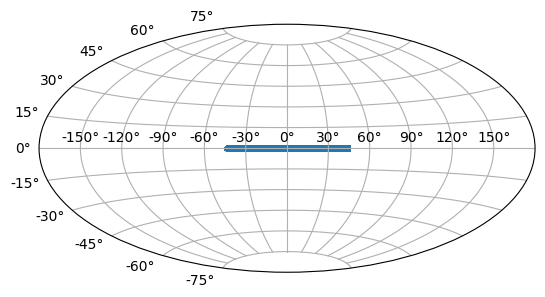

In [30]:
subplot(111,projection='aitoff')
scatter(np.radians(cat['RA']),np.radians(cat['DEC']),s=1)
grid(True)